- By: Alex Kwon
- Email: alex.kwon [at] hudsonthames [dot] org
- Reference 1: [Online Portfolio Selection](https://books.google.com/books/about/Online_Portfolio_Selection.html?id=R2fdCgAAQBAJ) by Li and Hoi
- Reference 2: [On-Line Portfolio Selection Using Multiplicative Updates](http://web.cs.iastate.edu/~honavar/portfolio-selection.pdf) by Helmbold, Schapire, Singer, and Wurmuth

# Online Portfolio Selection - Momentum

## Abstract

Momentum strategies have been a popular quantitative strategy in recent decades as the simple but powerful trend-following allows investors to exponentially increase their returns. This module will implement two types of momentum strategy with one following the best-performing assets in the last period and the other following the Best Constant Rebalanced Portfolio until the last period.

In this notebook, we will dive into Exponential Gradient, a momentum strategy that focuses on the best performing asset of the last time period. The portfolio shifts its weights to the best performing asset of the last period with an adjustment of $\eta$, the learning rate. A higher value of $\eta$ indicates the aggressiveness of the strategy to match the best performing assets. A lower value of $\eta$ indicates the passiveness of the strategy to match the best performing assets.

In traditional papers, $\eta$ of 0.05 was proved to be the most profitable strategy in the long run, and through this analysis, we find out that it is true for the datasets previous researchers have used. However, in the new data that I explored, I found that with the inclusion of a dominant asset and higher daily volatility, a higher eta value is necessary to follow the best stock. From the $\eta$ values explored, a value around 20 produced the best results that would follow the best performing asset and would not deviate too much with market noise.

Follow the Leader and Regularized Leader is another momentum strategy that tracks the best constant rebalanced portfolio until the last time period. The portfolio shifts its weights to the BCRP with an adjustment of $\beta$, the regularization rate. A higher value of $\beta$ indicates the passiveness of the strategy to match the BCRP, and a lower value of $\beta$ indicates the aggressiveness of the strategy to match the BCRP.


**1. Exponential Gradient**
   - Multiplicative Update
   - Gradient Projection
   - Expectation Maximization
   
**2. Follow the Leader**
   - Follow the Regularized Leader
    
**3. Data Exploration**
   - NYSE: 1962-1984
   - DJIA: 2001-2003
   - TSE: 1994-1998
   - SP500: 1998-2003
   - MSCI: 1993-2020
   - US Equity: 2011-2020

# Strategy

Throughout the next couple weeks, we will be releasing notebooks on the following strategies

[**Benchmarks**](https://github.com/hudson-and-thames/research/blob/master/Online%20Portfolio%20Selection/Introduction%20to%20Online%20Portfolio%20Selection.ipynb)
- Buy and Hold
- Best Stock
- Constant Rebalanced Portfolio
- Best Constant Rebalanced Portfolio

**Momentum**
- Exponential Gradient
- Follow the Leader
- Follow the Regularized Leader

**Mean Reversion**
- Confidence Weighted Mean Reversion
- Passive Aggressive Mean Reversion
- Online Moving Average Reversion
- Robust Median Reversion

**Pattern Matching**
- Nonparametric Histogram/Kernel-Based/Nearest Neighbor Log-Optimal
- Correlation Driven Nonparametric Learning
- Nonparametric Kernel-Based Semi-Log-Optimal/Markowitz/GV

**Meta Algorithm**
- Aggregating Algorithm
- Fast Universalization Algorithm
- Online Gradient Updates
- Online Newton Updates
- Follow the Leading History

**Universal Portfolio**
- Universal Portfolio
- CORN-U
- CORN-K
- SCORN-K
- FCORN-K

## 1. Exponential Gradient

Exponential Gradient strategies focus on the following optimization problem, which tracks the best performing stock with a learning rate, $\eta$, but also regularizes the new portfolio weight to prevent drastic changes from the previous portfolio.

$b_{t+1} = \underset{b \in \Delta_m}{\arg\max} \: \eta \log b \cdot x_t - R(b,b_t)$

As a review, $b_t$ is the portfolio weights for time $t$, and $x_t$ is the price relatives for time $t$.

Exponential Gradients have an extremely efficient computational time that scales with the number of assets, and broadly speaking, there are three update methods to iteratively update the selection of portfolio weights.

### 1.1 Multiplicative Update 

David Helmbold first proposed a regularization term that adopts relative entropy.

$R(b,b_t) = \overset{m}{\underset{i=1}{\sum}}b_i \log \frac{b_i}{b_{t,i}}$

    
Using log's first order taylor expansion of $b_i$

$\log b \cdot x_t \approx \log(b_t \cdot x_t) + \frac{x_t}{b_t \cdot x_t}(b-b_t)$

Multiplicative update algorithm can be stated as the following.

$b_{t+1} = b_t \cdot \exp \left( \eta \frac{x_t}{b_t \cdot x_t} \right) / Z$, where $Z$ is a normalization term to sum the weights to 1

### 1.2 Gradient Projection

Instead of relative entropy, gradient projection adopts an L2-regularization term for the optimization equation.

$R(b,b_t) = \frac{1}{2}\overset{m}{\underset{i=1}{\sum}}(b_i - b_{t,i})^2$

Gradient projection can then be iteratively updated with the following equation.

$b_{t+1} = b_t + \eta \cdot \left( \frac{x_t}{b_t \cdot x_t} - \frac{1}{m} \sum_{j=1}^{m} \frac{x_t}{b_t \cdot x_t} \right)$

### 1.3 Expectation Maximization

Lastly, Expectation Maximization uses a $\chi^2$ regularization term.

$R(b-b_t)=\frac{1}{2}\overset{m}{\underset{i=1}{\sum}}\frac{(b_i - b_{t,i})^2}{b_{t,i}}$

Then the corresponding update rule becomes

$b_{t+1} = b_t \cdot \left( \eta \cdot \left( \frac{x_t}{b_t \cdot x_t} - 1 \right) + 1 \right)$


Each of these update rules can be called using the **ExponentialGradient()** with different update rules with the default being multiplicative updates.

Learning rates can also be adjusted by setting **eta**, and if no values are stated default will be 0.05

    - Multiplicative Update: ExponentialGradient('MU', eta=0.05)
    - Gradient Projection: ExponentialGradient('GP', eta=0.1)
    - Expectation Maximization: ExponentialGradient('EM', eta=1)

## 2. Follow the Leader

The biggest drawback of using Exponential Gradient is the failure to look at the changes before the latest period. Follow the Leader mediates this shortfall by directly tracking the Best Constant Rebalanced Portfolio; therefore, FTL looks at the whole history of the data and calculates the portfolio weights that would have had the maximum returns.

$b_{t+1} = b^{\bf{\star}}_t = \underset{b \in \Delta_m}{\arg\max} \overset{t}{\underset{\tau=1}{\sum}} \: \log(b \cdot x_{\tau})$

### 2.1 Follow the Regularized Leader

Follow the Regularized Leader adds an additional regularization term to prevent a drastic deviation in each period.

$b_{t+1} = \underset{b \in \Delta_m}{\arg\max} \overset{t}{\underset{\tau=1}{\sum}} \: \log(b \cdot x_{\tau}) - \frac{\beta}{2}R(b)$

Each of these strategies can be called using the **FollowTheLeader()** and **FollowTheRegularizedLeader()**.

The regularization term for FTRL can also be adjusted by setting **beta**.

    - Follow the Leader: FollowTheLeader()
    - Follow the Regularized Leader: FollowTheRegularizedLeader(beta=0.5)

In [1]:
import pandas as pd
import numpy as np
import pickle
import optuna
import matplotlib.pyplot as plt
from mlfinlab.online_portfolio_selection import *
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "svg" # Toggle for GitHub rendering

/Users/alexkwon/opt/anaconda3/envs/ht/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.

/Users/alexkwon/opt/anaconda3/envs/ht/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.





Support us on Patreon: https://www.patreon.com/HudsonThames

MlFinLab needs you! We need your help for us to keep on maintaining and implementing academic research based on 
financial machine learning (for open-source). In order for us to continue we need to raise $4000 of monthly donations
via Patreon - by December 2020. If we can't reach our goal, we will need to adopt more of a paid for service. We thought
that the best and least impactful course of action (should we not reach our goal) is to leave the package as open-source
but to make the documentation (ReadTheDocs) a paid for service. This is the ultimate litmus test, if the package is a 
value add, then we need the community to help us keep it going.

Our road map for 2020 is to implement the text book: Machine Learning for Asset Managers by Marcos Lopez de Prado, 
as well as a few papers from the Journal of Financial Data Science. We are hiring a full time developer for 3 months 
to help us reach our goals. The money that you

## Import Data

More information on these datasets is available [here](https://github.com/hudson-and-thames/research/blob/master/Online%20Portfolio%20Selection/Data%20Selection.ipynb).

In [2]:
msci = pd.read_csv('data/MSCI.csv', parse_dates=True, index_col='Date').dropna()[1:]
us_equity = pd.read_csv('data/US_Equity.csv', parse_dates=True, index_col='Date')
djia = pd.read_csv('data/DJIA.csv', parse_dates=True, index_col='Date')
nyse = pd.read_csv('data/NYSE.csv', parse_dates=True, index_col='Date')
sp500 = pd.read_csv('data/SP500.csv', parse_dates=True, index_col='Date')
tse = pd.read_csv('data/TSE.csv', parse_dates=True, index_col='Date')

## 3.1 NYSE: 1961-1984

We will first look at the dataset covered by Thomas Cover's original Universal Portfolio.

We will be using Optuna and dividing the parameters into two sets. The first set will include parameter values between 0 and 1 to emphasize the importance of adhering to the previous portfolio weights, and the second set will examine values between 1 and 100, which will present significant returns if changing weights benefit the overall returns.

In [3]:
data = 'NYSE'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    nyse_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    nyse_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    nyse_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    nyse_large_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/FTL/list.pickle', 'rb') as f:
    nyse_ftl = pickle.load(f)
with open('pickled/' + data + '/FTRL/small_beta_list.pickle', 'rb') as f:
    nyse_small_beta_list = pickle.load(f)
with open('pickled/' + data + '/FTRL/small_beta_optuna.pickle', 'rb') as f:
    nyse_small_beta_optuna = pickle.load(f)

#### Hyperparameter Tuning

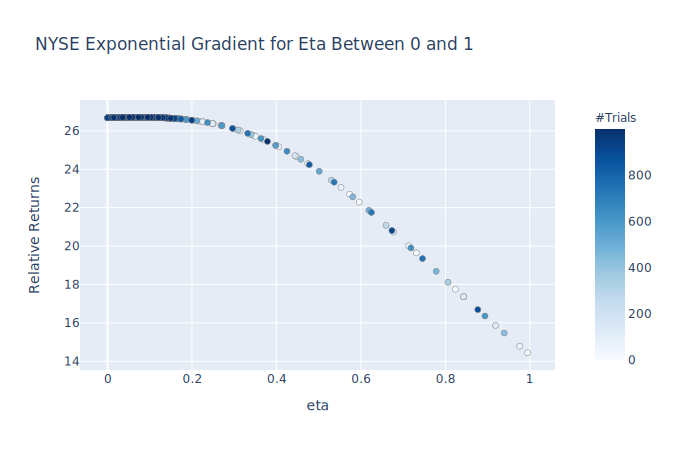

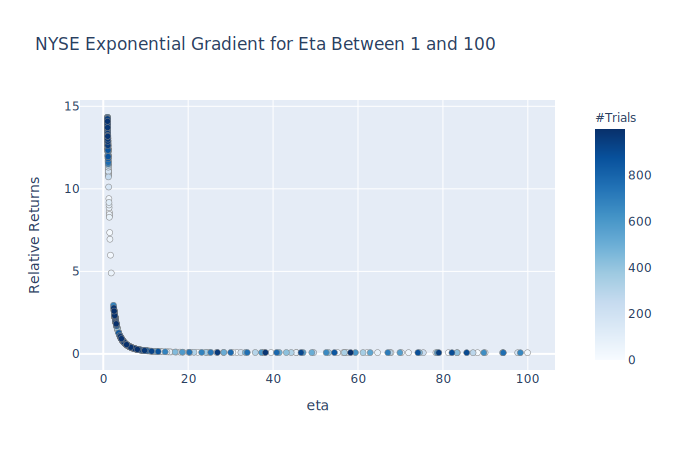

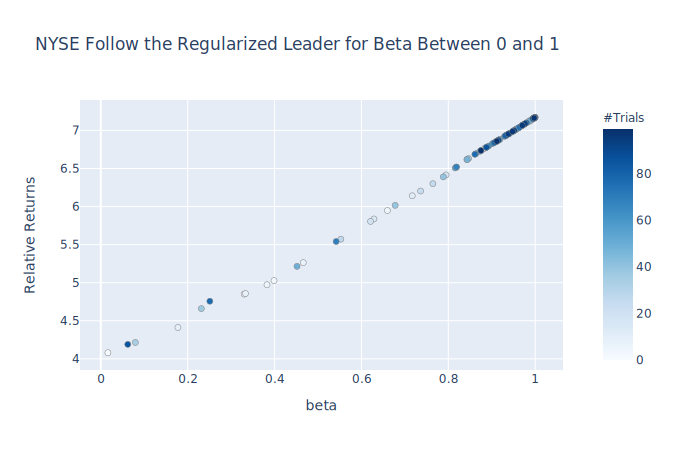

In [4]:
fig = optuna.visualization.plot_slice(nyse_small_eta_optuna)
fig.update_layout(title_text="NYSE Exponential Gradient for Eta Between 0 and 1", yaxis_title_text="Relative Returns")
display(fig)

fig = optuna.visualization.plot_slice(nyse_large_eta_optuna)
fig.update_layout(title_text="NYSE Exponential Gradient for Eta Between 1 and 100", yaxis_title_text="Relative Returns")
display(fig)

fig = optuna.visualization.plot_slice(nyse_small_beta_optuna)
fig.update_layout(title_text="NYSE Follow the Regularized Leader for Beta Between 0 and 1", yaxis_title_text="Relative Returns")
display(fig)

# fig = optuna.visualization.plot_slice(nyse_large_eta_optuna)
# fig.update_layout(title_text="NYSE for Eta Between 1 and 100", yaxis_title_text="Relative Returns")
# display(fig)

#### Best Parameters for Exponential Gradient

In [5]:
print("Best parameter: ", nyse_small_eta_optuna.best_params['eta'])
print("Best returns: ", nyse_small_eta_optuna.best_trial.value)
print("Best trial number: ", nyse_small_eta_optuna.best_trial.number)

Best parameter:  0.07364226809952339
Best returns:  26.706310066442498
Best trial number:  397


From Helmbold's original paper, $\eta$ of 0.05 was suggested for Exponential Gradient, and through our tuning, we discovered that the best parameter was 0.0736, which is very similar to the suggested $\eta$ value.

#### Best Parameters for Follow the Regularized Leader

In [6]:
# print("Best parameter: ", nyse_small_eta_optuna.best_params['eta'])
# print("Best returns: ", nyse_small_eta_optuna.best_trial.value)
# print("Best trial number: ", nyse_small_eta_optuna.best_trial.number)

Follow the Regularized Leader's $\beta$ with the highest returns indicate similar returns to the highest returns by Exponential Gradient.

#### Benchmarks Comparison

In [7]:
nyse_bah = BuyAndHold()
nyse_bah.allocate(nyse)
nyse_beststock = BestStock()
nyse_beststock.allocate(nyse)
nyse_crp = ConstantRebalancedPortfolio()
nyse_crp.allocate(nyse)

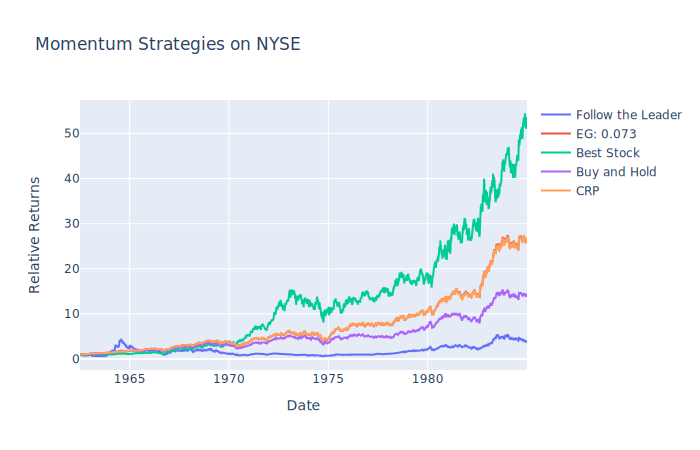

In [8]:
fig = go.Figure()
idx = nyse_bah.portfolio_return.index
# fig.add_trace(go.Scatter(x=idx, y=nyse_small_eta_list[397].portfolio_return['Returns'], name="FTRL Beta: "))
fig.add_trace(go.Scatter(x=idx, y=nyse_ftl.portfolio_return['Returns'], name="Follow the Leader"))
fig.add_trace(go.Scatter(x=idx, y=nyse_small_eta_list[397].portfolio_return['Returns'], name="EG: 0.073"))
fig.add_trace(go.Scatter(x=idx, y=nyse_beststock.portfolio_return['Returns'], name="Best Stock"))
fig.add_trace(go.Scatter(x=idx, y=nyse_bah.portfolio_return['Returns'], name="Buy and Hold"))
fig.add_trace(go.Scatter(x=idx, y=nyse_crp.portfolio_return['Returns'], name="CRP"))
fig.update_layout(title='Momentum Strategies on NYSE', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

A simple buy and hold returned 12, whereas the best performing Exponential Gradient returned 26.7.

For a dataset where all stocks increase in value and a uniform buy and hold strategy is profitable, a low EG value was adequate. Huge deviations from the original portfolio weight were not necessary and blindly following the best performing asset often decreased the returns as the momentum for these sets of stocks did not continue on a daily basis.

## 3.2 DJIA: 2001-2003

DJIA from 2001 to 2003 provides strikingly different patterns compared to the previous NYSE data. Only 5 companies increased in price as most declined at a steady rate.

In [9]:
djia.tail(3)

,Alcoa,GE,Johnson&Johnson,Microsoft,American Express,General Motors,JP Morgan Chase,P&G,Boeing,Home Depot,...,DuPont,IBM,Philip Morris,Walmart,Walt Disney,Intel,Merck,ExxonMobil,Eastman Kodak,International Paper
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-10,0.697461,0.536499,1.158364,1.166458,0.682517,0.713556,0.535059,1.154093,0.541081,0.419518,...,0.918440,0.926556,0.975148,0.883299,0.584353,0.508910,0.671042,0.826648,0.993581,0.916951
2003-01-13,0.699602,0.536289,1.134872,1.176262,0.688953,0.725050,0.538811,1.154897,0.548274,0.426905,...,0.912182,0.924760,0.979408,0.877481,0.589183,0.507742,0.670930,0.823364,0.986421,0.923770
2003-01-14,0.708474,0.537753,1.141353,1.188361,0.686986,0.738916,0.544934,1.157175,0.545876,0.428655,...,0.917814,0.936067,0.978698,0.879706,0.594656,0.519720,0.671042,0.830870,0.987161,0.931076


In [10]:
data = 'DJIA'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    djia_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    djia_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    djia_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    djia_large_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/FTL/list.pickle', 'rb') as f:
    djia_ftl = pickle.load(f)
with open('pickled/' + data + '/FTRL/small_beta_list.pickle', 'rb') as f:
    djia_small_beta_list = pickle.load(f)
with open('pickled/' + data + '/FTRL/small_beta_optuna.pickle', 'rb') as f:
    djia_small_beta_optuna = pickle.load(f)
with open('pickled/' + data + '/FTRL/large_beta_list.pickle', 'rb') as f:
    djia_large_beta_list = pickle.load(f)
with open('pickled/' + data + '/FTRL/large_beta_optuna.pickle', 'rb') as f:
    djia_large_beta_optuna = pickle.load(f)

#### Hyperparameter Tuning

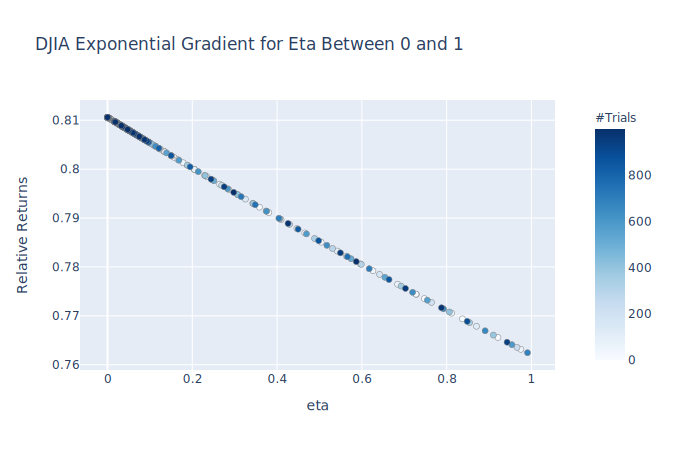

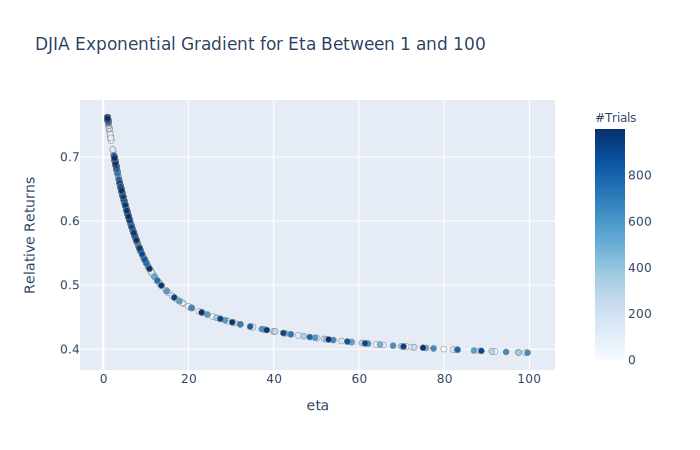

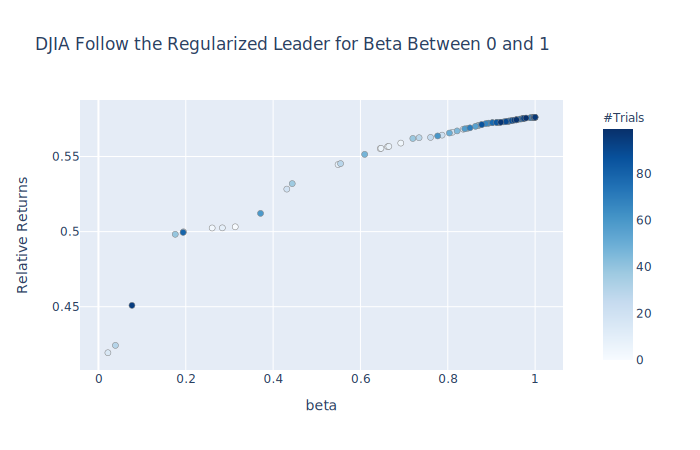

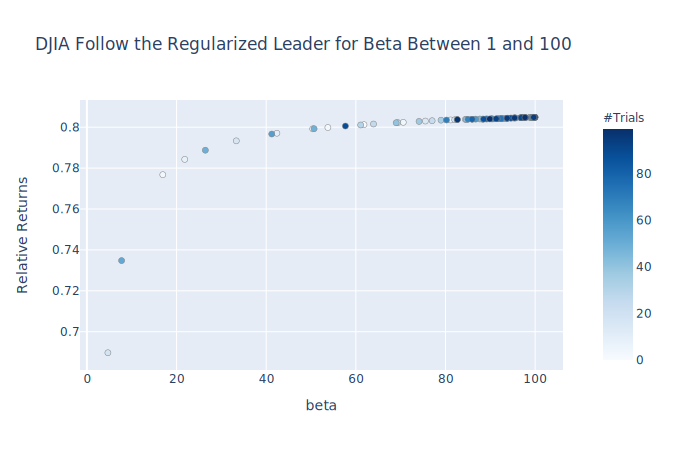

In [11]:
fig = optuna.visualization.plot_slice(djia_small_eta_optuna)
fig.update_layout(title_text="DJIA Exponential Gradient for Eta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(djia_large_eta_optuna)
fig.update_layout(title_text="DJIA Exponential Gradient for Eta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(djia_small_beta_optuna)
fig.update_layout(title_text="DJIA Follow the Regularized Leader for Beta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(djia_large_beta_optuna)
fig.update_layout(title_text="DJIA Follow the Regularized Leader for Beta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

The ideal $\eta$ for Exponential Gradient was a value very close to 0, and ideal $\beta$ was close to 100. These parameters suggest that the weights should not change from its original set value. The regularization term in FTRL prevents the strategy from tracking the BCRP, and the learning rate in EG prevents the strategy from tracking the Best Stock.

#### Best Parameters for Exponential Gradient

In [12]:
print("Best parameter: ", djia_small_eta_optuna.best_params['eta'])
print("Best returns: ", djia_small_eta_optuna.best_trial.value)
print("Best trial number: ", djia_small_eta_optuna.best_trial.number)

Best parameter:  1.473309438842684e-06
Best returns:  0.8106059699948273
Best trial number:  736


#### Best Parameters for Follow the Regularized Leader

In [13]:
print("Best parameter: ", djia_large_beta_optuna.best_params['beta'])
print("Best returns: ", djia_large_beta_optuna.best_trial.value)
print("Best trial number: ", djia_large_beta_optuna.best_trial.number)

Best parameter:  99.9738049093456
Best returns:  0.8048626130415245
Best trial number:  54


#### Benchmarks Comparison

In [14]:
djia_bah = BuyAndHold()
djia_bah.allocate(djia)
djia_crp = ConstantRebalancedPortfolio()
djia_crp.allocate(djia)
djia_beststock = BestStock()
djia_beststock.allocate(djia)

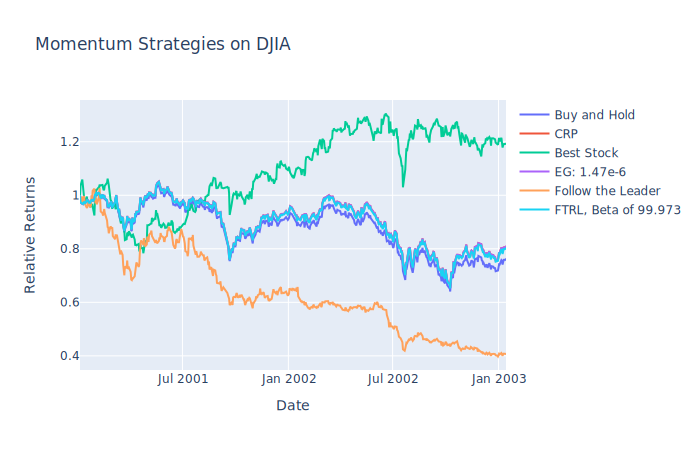

In [15]:
fig = go.Figure()
idx = djia_bah.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=djia_bah.portfolio_return['Returns'], name="Buy and Hold"))
fig.add_trace(go.Scatter(x=idx, y=djia_crp.portfolio_return['Returns'], name="CRP"))
fig.add_trace(go.Scatter(x=idx, y=djia_beststock.portfolio_return['Returns'], name="Best Stock"))
fig.add_trace(go.Scatter(x=idx, y=djia_small_eta_list[djia_small_eta_optuna.best_trial.number].portfolio_return['Returns'], name="EG: 1.47e-6"))
fig.add_trace(go.Scatter(x=idx, y=djia_ftl.portfolio_return['Returns'], name="Follow the Leader"))
fig.add_trace(go.Scatter(x=idx, y=djia_large_beta_list[djia_large_beta_optuna.best_trial.number].portfolio_return['Returns'], name="FTRL, Beta of 99.973"))
fig.update_layout(title='Momentum Strategies on DJIA', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

For a market with a general downtrend, momentum strategies fail to make a significant effect on our returns. This is in line with the underlying concept for momentum where a strong trend in a direction is necessary to reap the rewards. With our current problem formulation that prevents shorting assets, a momentum strategy cannot produce meaningful returns in this environment. It is not surprising that both Exponential Gradient and Follow the Leader fail to have higher returns than a simple buy and hold strategy.

## TSE: 1994-1998

The Toronto Stock Exchange data includes a collection that may be unfamiliar to most researchers. It is a unique universe with half of the stocks decreasing in value. With a combination of both overperforming and underperforming stocks, selection strategies need to identify the ups and downs to have profitable returns.

In [16]:
tse.tail(4)

,Westcoast Energy,Seagram,TVX Gold,Transcanada,Thomson,Talisman,Trilon,Teck,TD Bank,Transalta,...,Cott Corp,Bombardier,Anderson,AUR Resources,Alcan Aluminum,Agnico-Eagle Mines,Alberta Energy,Air Canada,Aber Resources,Barrick Gold Corp
Date,,,,,,,,,,,,,,,,,,,,,
1998-12-28,1.706694,1.729760,0.314291,1.431531,2.488814,0.906779,4.099141,0.495611,2.892180,2.021149,...,0.176781,4.412507,0.900356,0.442871,1.653653,0.366799,1.979006,1.229973,2.092211,0.813941
1998-12-29,1.706694,1.805627,0.310862,1.433421,2.482107,0.887815,4.043995,0.488853,2.969661,2.021149,...,0.164154,4.422568,0.928060,0.451729,1.651682,0.375819,1.967120,1.219974,2.144851,0.829015
1998-12-30,1.706694,1.744934,0.312006,1.423886,2.371417,0.886091,4.043995,0.473084,2.961358,2.007911,...,0.162575,4.312004,0.910745,0.442871,1.645769,0.378825,1.943347,1.219974,2.171168,0.811202
1998-12-31,1.717958,1.767688,0.308578,1.427061,2.408317,0.929191,4.043995,0.504624,2.977971,1.994673,...,0.172045,4.422563,0.962685,0.460586,1.635914,0.378825,1.961168,1.229977,2.263269,0.816685


In [17]:
data = 'TSE'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    tse_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    tse_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    tse_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    tse_large_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/FTL/list.pickle', 'rb') as f:
    tse_ftl = pickle.load(f)
with open('pickled/' + data + '/FTRL/small_beta_list.pickle', 'rb') as f:
    tse_small_beta_list = pickle.load(f)
with open('pickled/' + data + '/FTRL/small_beta_optuna.pickle', 'rb') as f:
    tse_small_beta_optuna = pickle.load(f)
with open('pickled/' + data + '/FTRL/large_beta_list.pickle', 'rb') as f:
    tse_large_beta_list = pickle.load(f)
with open('pickled/' + data + '/FTRL/large_beta_optuna.pickle', 'rb') as f:
    tse_large_beta_optuna = pickle.load(f)

#### Hyperparameter Tuning

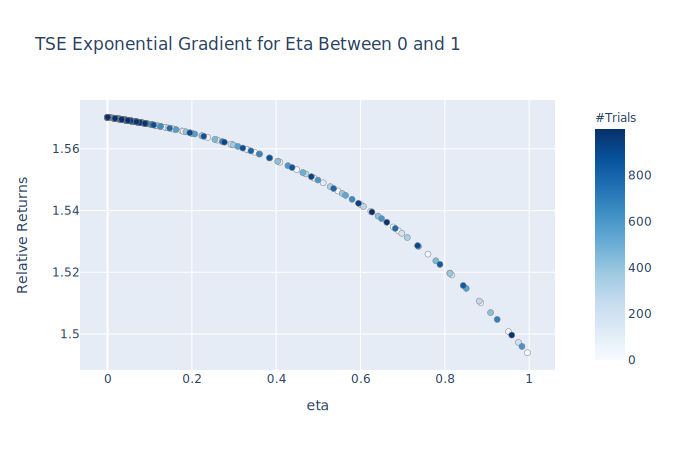

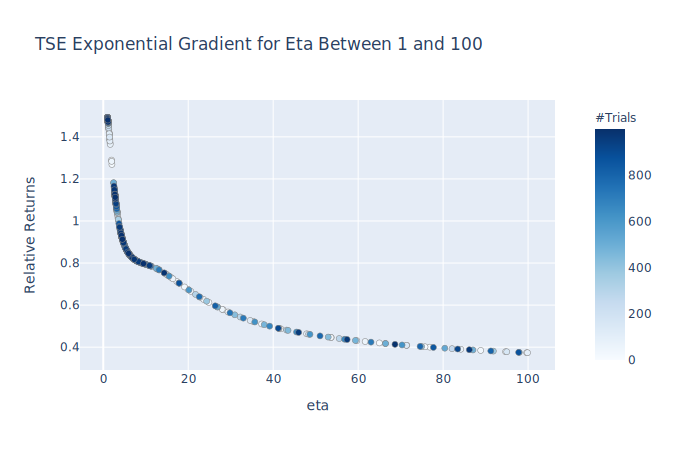

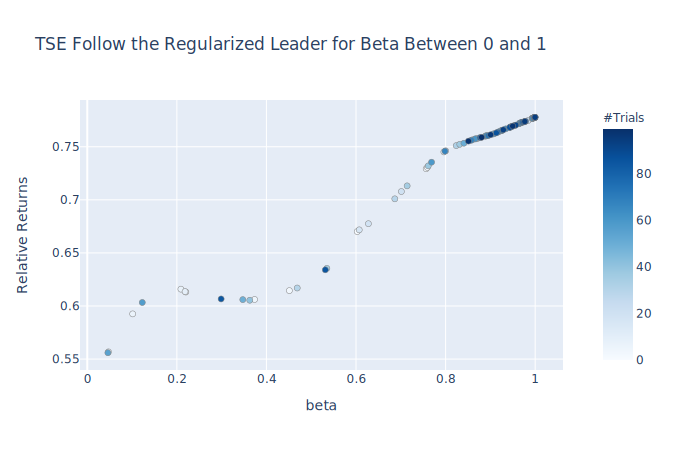

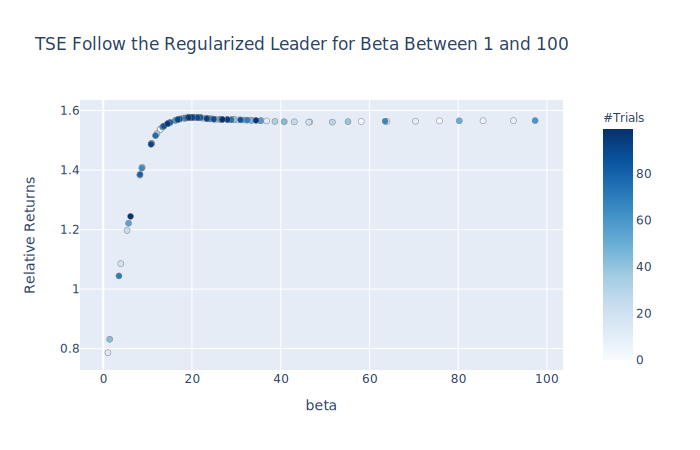

In [18]:
fig = optuna.visualization.plot_slice(tse_small_eta_optuna)
fig.update_layout(title_text="TSE Exponential Gradient for Eta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(tse_large_eta_optuna)
fig.update_layout(title_text="TSE Exponential Gradient for Eta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(tse_small_beta_optuna)
fig.update_layout(title_text="TSE Follow the Regularized Leader for Beta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(tse_large_beta_optuna)
fig.update_layout(title_text="TSE Follow the Regularized Leader for Beta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

TSE's ideal $\eta$ is close to 0, and ideal $\beta$ is 19.826. A magnitude of $\beta$ was necessary to lift FTRL returns, whereas $\eta$ of 0 was better for EG.

#### Best Parameters for Exponential Gradient

In [19]:
print("Best parameter: ", tse_small_eta_optuna.best_params['eta'])
print("Best returns: ", tse_small_eta_optuna.best_trial.value)
print("Best trial number: ", tse_small_eta_optuna.best_trial.number)

Best parameter:  2.612195774396946e-06
Best returns:  1.570249601140997
Best trial number:  264


#### Best Parameters for Follow the Regularized Leader

In [20]:
print("Best parameter: ", tse_large_beta_optuna.best_params['beta'])
print("Best returns: ", tse_large_beta_optuna.best_trial.value)
print("Best trial number: ", tse_large_beta_optuna.best_trial.number)

Best parameter:  19.826808495813783
Best returns:  1.577404460287935
Best trial number:  72


In [21]:
tse_bah = BuyAndHold()
tse_bah.allocate(tse)
tse_crp = ConstantRebalancedPortfolio()
tse_crp.allocate(tse)
tse_beststock = BestStock()
tse_beststock.allocate(tse)

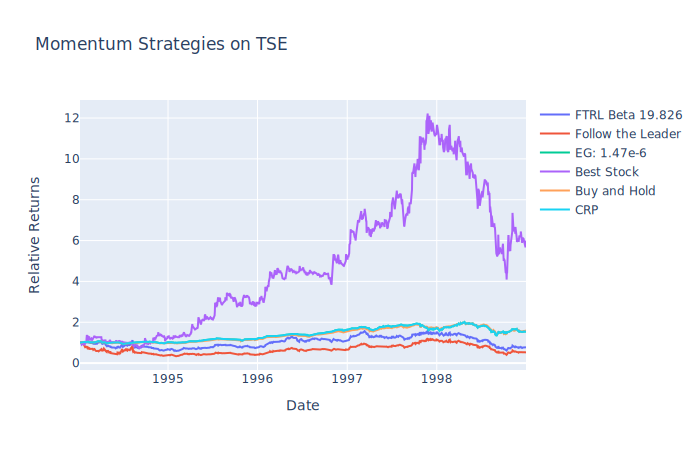

In [22]:
fig = go.Figure()
idx = tse_bah.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=tse_large_beta_list[tse_large_beta_optuna.best_trial.number].portfolio_return['Returns'], name="FTRL Beta 19.826"))
fig.add_trace(go.Scatter(x=idx, y=tse_ftl.portfolio_return['Returns'], name="Follow the Leader"))
fig.add_trace(go.Scatter(x=idx, y=tse_small_eta_list[tse_small_eta_optuna.best_trial.number].portfolio_return['Returns'], name="EG: 1.47e-6"))
fig.add_trace(go.Scatter(x=idx, y=tse_beststock.portfolio_return['Returns'], name="Best Stock"))
fig.add_trace(go.Scatter(x=idx, y=tse_bah.portfolio_return['Returns'], name="Buy and Hold"))
fig.add_trace(go.Scatter(x=idx, y=tse_crp.portfolio_return['Returns'], name="CRP"))
fig.update_layout(title='Momentum Strategies on TSE', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

The highest returns for FTRL and EG were 1.57, which was achieved by both CRP and buy and hold. Accounting for transaction cost and rebalancing, momentum strategy was ineffective for TSE as well. The presence of such a volatile but performing best stock in TSE would suggest that the momentum strategies would follow these trends. However, following the best stock graph, the movements are not predictive and extremely sudden. With every increase, a slight decrease follows, which represents a mean reversion trend and not a momentum one.

## SP500: 1998-2003

This dataset also includes the bear and bull run during turbulent times. It is longer than the DJIA data by 3 years and includes many companies that are familiar to us. SP500 during this time goes through the bear market in 2000, and in the long run, all but 5 companies increase in value.

In [23]:
sp500.tail(3)

,GE,Microsoft,Walmart,ExxonMobil,Pfizer,Citigroup,Johnson & Johnson,AIG,IBM,Merck,...,Verizon,Wells Fargo,Amgen,Dell,PepsiCo,SBC Comms,Fannie Mae,Chevron,Viacom,Eli Lilly
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-29,0.933647,1.522519,2.443176,1.094143,1.210898,1.328937,1.610757,1.415379,1.520854,1.029315,...,0.828039,1.227103,3.870403,2.363139,1.125278,0.649074,1.125670,0.837851,1.898274,0.888341
2003-01-30,0.914188,1.471575,2.416255,1.074102,1.177603,1.278471,1.584321,1.359959,1.482605,1.012962,...,0.817483,1.213748,3.780669,2.255850,1.075278,0.636530,1.091298,0.823737,1.823463,0.861215
2003-01-31,0.938107,1.447781,2.427938,1.103840,1.203367,1.284079,1.647952,1.382178,1.480712,1.029315,...,0.841895,1.240458,3.779186,2.225996,1.124444,0.652276,1.111921,0.826304,1.860628,0.873835


In [24]:
data = 'SP500'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    sp500_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    sp500_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    sp500_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    sp500_large_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/FTL/list.pickle', 'rb') as f:
    sp500_ftl = pickle.load(f)
with open('pickled/' + data + '/FTRL/small_beta_list.pickle', 'rb') as f:
    sp500_small_beta_list = pickle.load(f)
with open('pickled/' + data + '/FTRL/small_beta_optuna.pickle', 'rb') as f:
    sp500_small_beta_optuna = pickle.load(f)
with open('pickled/' + data + '/FTRL/large_beta_list.pickle', 'rb') as f:
    sp500_large_beta_list = pickle.load(f)
with open('pickled/' + data + '/FTRL/large_beta_optuna.pickle', 'rb') as f:
    sp500_large_beta_optuna = pickle.load(f)

#### Hyperparameter Tuning

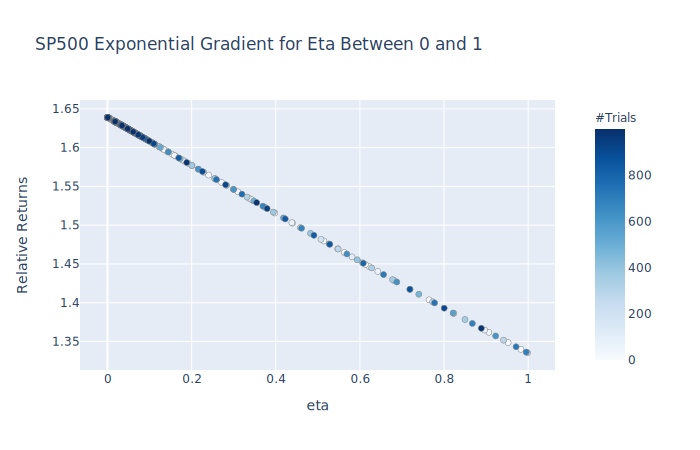

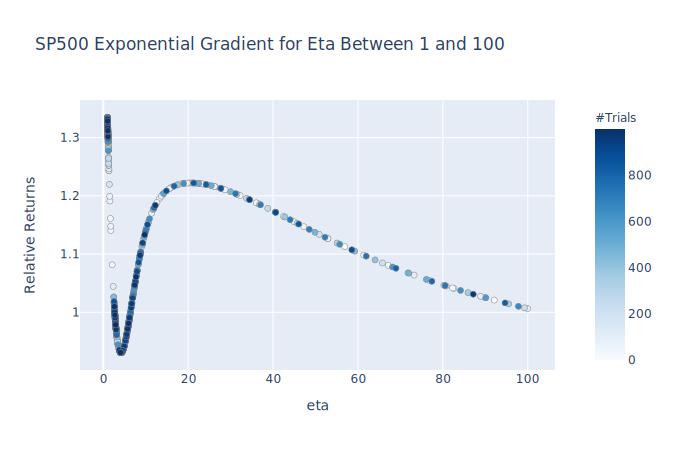

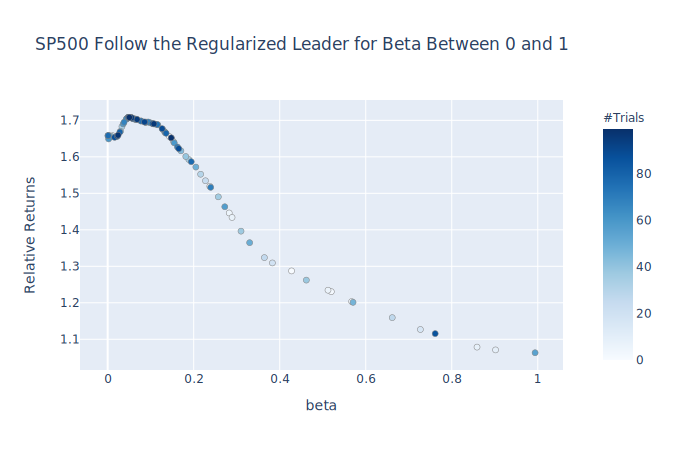

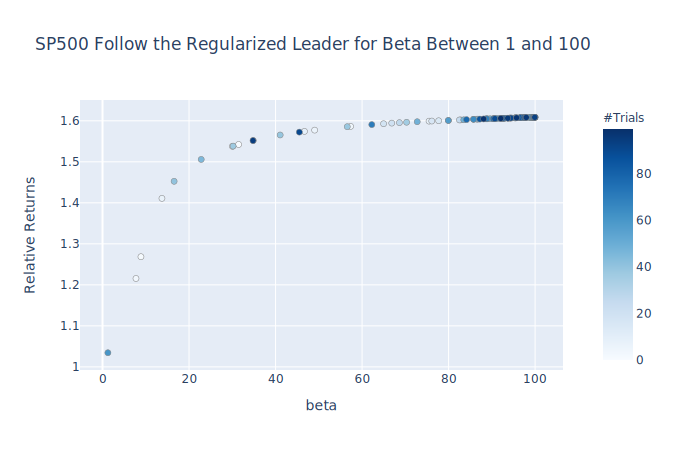

In [25]:
fig = optuna.visualization.plot_slice(sp500_small_eta_optuna)
fig.update_layout(title_text="SP500 Exponential Gradient for Eta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(sp500_large_eta_optuna)
fig.update_layout(title_text="SP500 Exponential Gradient for Eta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(sp500_small_beta_optuna)
fig.update_layout(title_text="SP500 Follow the Regularized Leader for Beta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(sp500_large_beta_optuna)
fig.update_layout(title_text="SP500 Follow the Regularized Leader for Beta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

Ideal $\eta$ is 0, and $\beta$ is 0.048. For the FTRL, we see an increase in returns for higher values of $\beta$. For $\beta$ of 100, the returns are very close to returns by the best parameters.

#### Best Parameters for Exponential Gradient

In [26]:
print("Best parameter: ", sp500_small_eta_optuna.best_params['eta'])
print("Best returns: ", sp500_small_eta_optuna.best_trial.value)
print("Best trial number: ", sp500_small_eta_optuna.best_trial.number)

Best parameter:  2.395215871893962e-06
Best returns:  1.6391662351711398
Best trial number:  152


#### Best Parameters for Follow the Regularized Leader

In [27]:
print("Best parameter: ", sp500_small_beta_optuna.best_params['beta'])
print("Best returns: ", sp500_small_beta_optuna.best_trial.value)
print("Best trial number: ", sp500_small_beta_optuna.best_trial.number)

Best parameter:  0.04845585288695317
Best returns:  1.7084933549212573
Best trial number:  90


#### Benchmarks Comparison

In [28]:
sp500_bah = BuyAndHold()
sp500_bah.allocate(sp500)
sp500_crp = ConstantRebalancedPortfolio()
sp500_crp.allocate(sp500)
sp500_beststock = BestStock()
sp500_beststock.allocate(sp500)

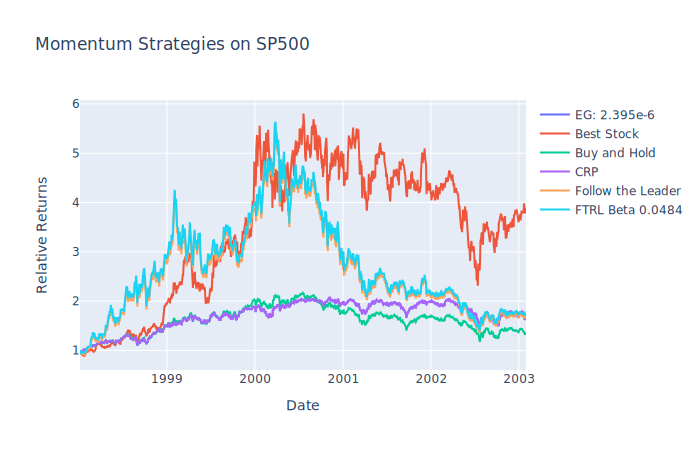

In [29]:
fig = go.Figure()
idx = sp500_bah.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=sp500_small_eta_list[sp500_small_eta_optuna.best_trial.number].portfolio_return['Returns'], name="EG: 2.395e-6"))
fig.add_trace(go.Scatter(x=idx, y=sp500_beststock.portfolio_return['Returns'], name="Best Stock"))
fig.add_trace(go.Scatter(x=idx, y=sp500_bah.portfolio_return['Returns'], name="Buy and Hold"))
fig.add_trace(go.Scatter(x=idx, y=sp500_crp.portfolio_return['Returns'], name="CRP"))
fig.add_trace(go.Scatter(x=idx, y=sp500_ftl.portfolio_return['Returns'], name="Follow the Leader"))
fig.add_trace(go.Scatter(x=idx, y=sp500_small_beta_list[sp500_small_beta_optuna.best_trial.number].portfolio_return['Returns'], name="FTRL Beta 0.0484"))
fig.update_layout(title='Momentum Strategies on SP500', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

SP500 during this time represents a tale of two periods. The first half has a momentum rally with FTRL returning the highest returns; however, after the peak from 2000, the portfolio rapidly decreases and converges to the rest of the strategies.

Follow the Leader, CRP, and EG all have similar returns that are marginally higher than a buy and hold, and this is another example where a lack of clear direction and continuous momentum hinders the ability to effectively predict the change in prices.

## MSCI: 1993-2020

Different from traditional assets, the world indexes capture much more than just the price changes of individual companies. With an overarching representation of the countries' market states, these market indexes will present a different idea for applications of online portfolio selection strategies.

In [30]:
msci.tail(3)

,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Hong Kong,Ireland,...,Netherlands,New Zealand,Norway,Portugal,Singapore,Spain,Sweden,Switzerland,United Kingdom,USA
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-21,581.392916,683.811303,1013.110604,1344.400758,10364.108501,416.329214,1448.298495,1588.740842,10181.002893,152.589494,...,2861.091981,161.992536,1631.854348,59.551533,2898.845186,289.943628,5996.494228,5729.337370,820.542785,2608.716015
2020-04-22,583.727898,704.832919,1020.682569,1382.745761,10388.209613,429.808850,1460.761507,1608.447299,10210.902283,156.841081,...,2930.770175,159.844927,1619.443584,60.773371,2895.229087,293.517799,6166.523111,5774.674583,842.396712,2669.372691
2020-04-23,590.102820,729.285719,1044.098476,1390.229972,10519.731506,434.347830,1475.563583,1624.477846,10254.069670,157.861220,...,2934.834695,161.938275,1669.657666,60.942110,2899.756263,295.120247,6274.965618,5757.703898,854.816085,2668.272058


In [31]:
data = 'MSCI'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    msci_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    msci_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    msci_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    msci_large_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/FTL/list.pickle', 'rb') as f:
    msci_ftl = pickle.load(f)
with open('pickled/' + data + '/FTRL/small_beta_list.pickle', 'rb') as f:
    msci_small_beta_list = pickle.load(f)
with open('pickled/' + data + '/FTRL/small_beta_optuna.pickle', 'rb') as f:
    msci_small_beta_optuna = pickle.load(f)
with open('pickled/' + data + '/FTRL/large_beta_list.pickle', 'rb') as f:
    msci_large_beta_list = pickle.load(f)
with open('pickled/' + data + '/FTRL/large_beta_optuna.pickle', 'rb') as f:
    msci_large_beta_optuna = pickle.load(f)

#### Hyperparameter Tuning

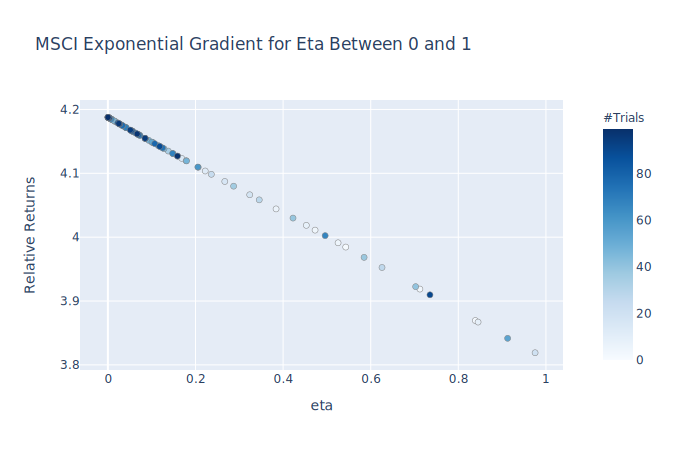

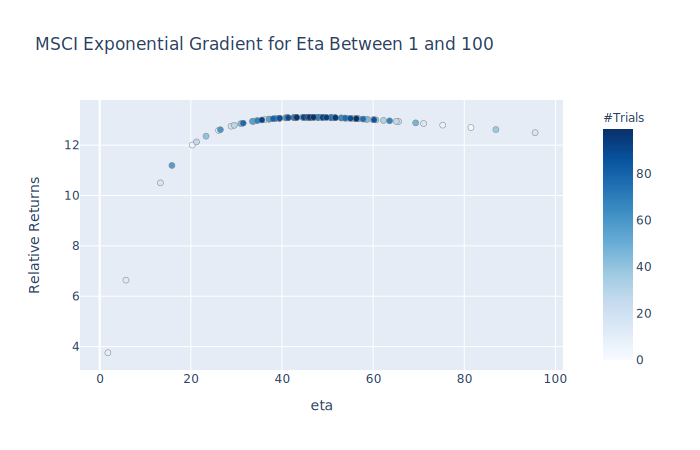

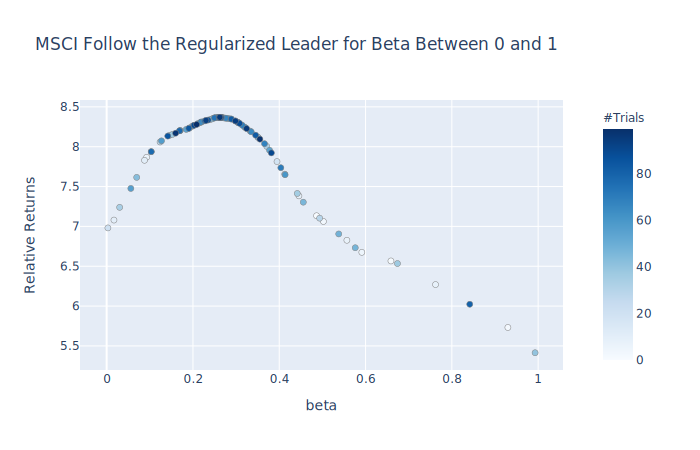

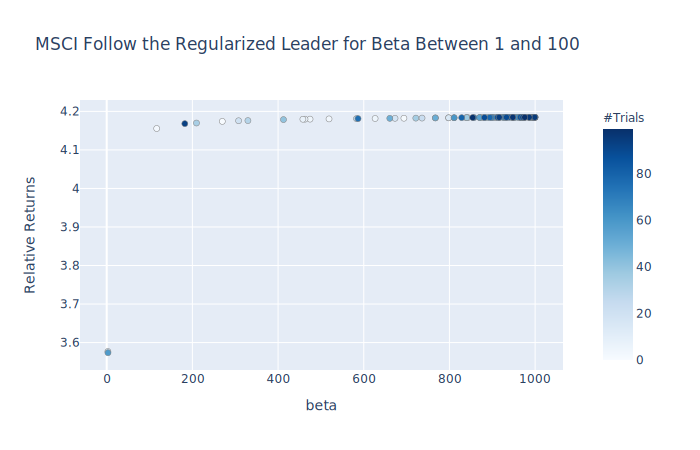

In [32]:
fig = optuna.visualization.plot_slice(msci_small_eta_optuna)
fig.update_layout(title_text="MSCI Exponential Gradient for Eta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(msci_large_eta_optuna)
fig.update_layout(title_text="MSCI Exponential Gradient for Eta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(msci_small_beta_optuna)
fig.update_layout(title_text="MSCI Follow the Regularized Leader for Beta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(msci_large_beta_optuna)
fig.update_layout(title_text="MSCI Follow the Regularized Leader for Beta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

Ideal $\eta$ is 46.25, and $\beta$ is 0.2627. We see $\eta$ and $\beta$ values that are different from previous datasets. Both values indicate a measure of slight regularization to adhere to previous portfolio weights, but also emphasizes the need to follow the trending asset.

#### Best Parameters for Exponential Gradient

In [33]:
print("Best parameter: ", msci_large_eta_optuna.best_params['eta'])
print("Best returns: ", msci_large_eta_optuna.best_trial.value)
print("Best trial number: ", msci_large_eta_optuna.best_trial.number)

Best parameter:  46.25850376593418
Best returns:  13.106872733587059
Best trial number:  51


#### Best Parameters for Follow the Regularized Leader

In [34]:
print("Best parameter: ", msci_small_beta_optuna.best_params['beta'])
print("Best returns: ", msci_small_beta_optuna.best_trial.value)
print("Best trial number: ", msci_small_beta_optuna.best_trial.number)

Best parameter:  0.26271956752919395
Best returns:  8.369657117883122
Best trial number:  74


#### Benchmarks Comparison

In [35]:
msci_bah = BuyAndHold()
msci_bah.allocate(msci)
msci_crp = ConstantRebalancedPortfolio()
msci_crp.allocate(msci)
msci_beststock = BestStock()
msci_beststock.allocate(msci)

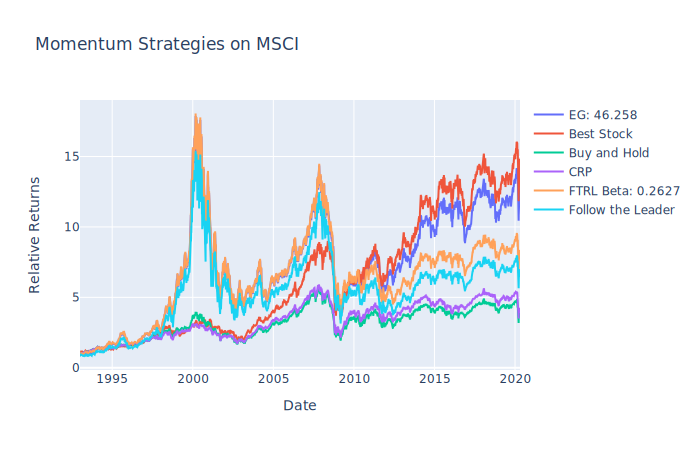

In [36]:
fig = go.Figure(); idx = msci_bah.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=msci_large_eta_list[msci_large_eta_optuna.best_trial.number].portfolio_return['Returns'], name="EG: 46.258"))
fig.add_trace(go.Scatter(x=idx, y=msci_beststock.portfolio_return['Returns'], name="Best Stock"))
fig.add_trace(go.Scatter(x=idx, y=msci_bah.portfolio_return['Returns'], name="Buy and Hold"))
fig.add_trace(go.Scatter(x=idx, y=msci_crp.portfolio_return['Returns'], name="CRP"))
fig.add_trace(go.Scatter(x=idx, y=msci_small_beta_list[msci_small_beta_optuna.best_trial.number].portfolio_return['Returns'], name="FTRL Beta: 0.2627"))
fig.add_trace(go.Scatter(x=idx, y=msci_ftl.portfolio_return['Returns'], name="Follow the Leader"))
fig.update_layout(title='Momentum Strategies on MSCI', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

For the MSCI dataset, we see the significantly higher returns of momentum strategies near the 2000s. Primarily because of Finland's rapid increase from the late 1990s, EG and FTL captured and put all of its weights onto Finland. If there is an asset that performs far better for a long period, momentum strategies are effective.

A higher $\eta$ and lower $\beta$ can blindly follow the performing asset and produce higher returns. However, the trend-following strategy is extremely volatile and can also create major drawbacks to the portfolio over time.

## US Equity: 2011-2020

In [37]:
us_equity.tail(3)

,AAPL,ABT,AMGN,AMZN,AXP,BAC,BRK-A,C,CAT,CMCSA,...,PG,PM,QCOM,SLB,T,UPS,USB,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-23,275.029999,93.940002,232.490005,2399.449951,82.459999,21.870001,278750.0,42.459999,112.910004,36.090000,...,119.400002,71.779999,73.809998,16.520000,29.500000,99.449997,33.369999,26.530001,128.529999,43.450001
2020-04-24,282.970001,94.059998,236.279999,2410.219971,83.169998,22.180000,279460.0,43.099998,114.040001,37.160000,...,118.779999,73.669998,76.040001,16.110001,29.709999,100.180000,34.000000,26.920000,129.440002,43.730000
2020-04-27,283.170013,94.949997,242.429993,2376.000000,85.059998,23.469999,281264.0,46.560001,115.199997,38.209999,...,117.449997,74.919998,75.980003,16.049999,30.540001,102.550003,35.880001,28.410000,128.300003,43.939999


In [38]:
data = 'equity'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    us_equity_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    us_equity_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    us_equity_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    us_equity_large_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/FTL/list.pickle', 'rb') as f:
    us_equity_ftl = pickle.load(f)
with open('pickled/' + data + '/FTRL/small_beta_list.pickle', 'rb') as f:
    us_equity_small_beta_list = pickle.load(f)
with open('pickled/' + data + '/FTRL/small_beta_optuna.pickle', 'rb') as f:
    us_equity_small_beta_optuna = pickle.load(f)
with open('pickled/' + data + '/FTRL/large_beta_list.pickle', 'rb') as f:
    us_equity_large_beta_list = pickle.load(f)
with open('pickled/' + data + '/FTRL/large_beta_optuna.pickle', 'rb') as f:
    us_equity_large_beta_optuna = pickle.load(f)

#### Hyperparameter Tuning

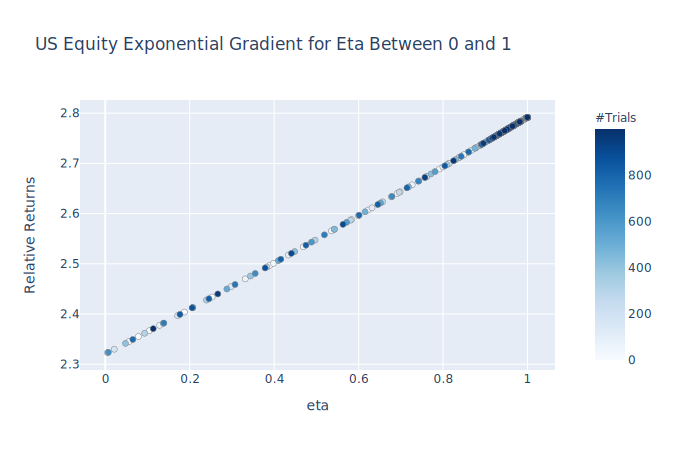

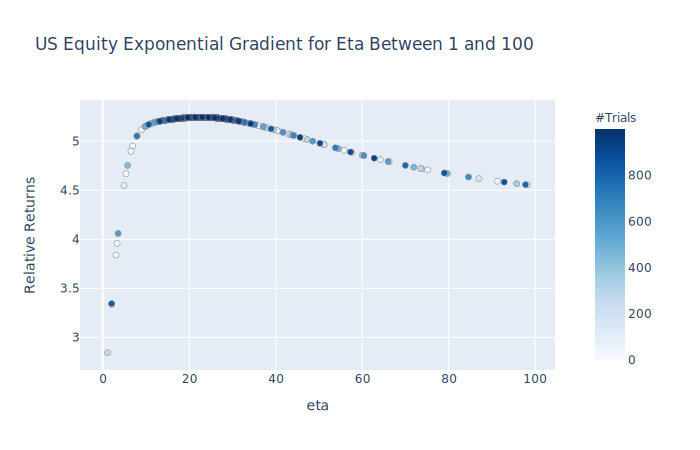

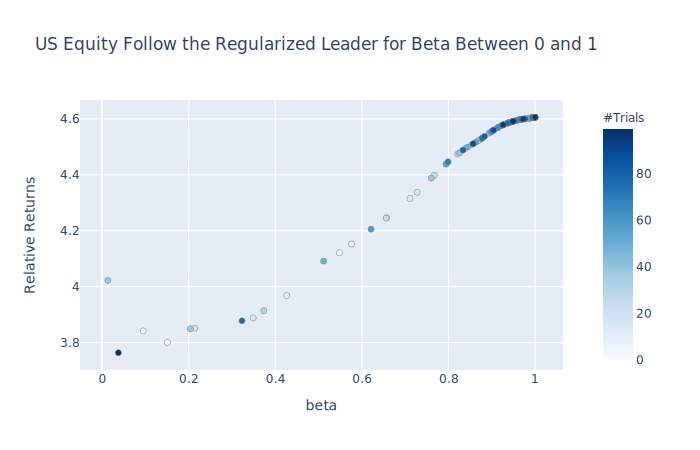

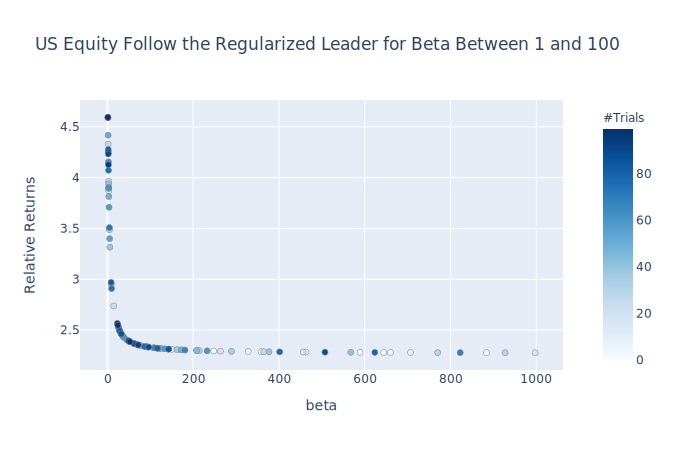

In [39]:
fig = optuna.visualization.plot_slice(us_equity_small_eta_optuna)
fig.update_layout(title_text="US Equity Exponential Gradient for Eta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(us_equity_large_eta_optuna)
fig.update_layout(title_text="US Equity Exponential Gradient for Eta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(us_equity_small_beta_optuna)
fig.update_layout(title_text="US Equity Follow the Regularized Leader for Beta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()

fig = optuna.visualization.plot_slice(us_equity_large_beta_optuna)
fig.update_layout(title_text="US Equity Follow the Regularized Leader for Beta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

Ideal $\eta$ is 22.67, and $\beta$ is 0.9999.

#### Best Parameters for Exponential Gradient

In [40]:
print("Best parameter: ", us_equity_large_eta_optuna.best_params['eta'])
print("Best returns: ", us_equity_large_eta_optuna.best_trial.value)
print("Best trial number: ", us_equity_large_eta_optuna.best_trial.number)

Best parameter:  22.67681684948512
Best returns:  5.244109792255035
Best trial number:  162


#### Best Parameters for Follow the Regularized Leader

In [41]:
print("Best parameter: ", us_equity_small_beta_optuna.best_params['beta'])
print("Best returns: ", us_equity_small_beta_optuna.best_trial.value)
print("Best trial number: ", us_equity_small_beta_optuna.best_trial.number)

Best parameter:  0.9998611745736707
Best returns:  4.605879759799056
Best trial number:  60


#### Benchmarks Comparison

In [42]:
us_equity_bah = BuyAndHold()
us_equity_bah.allocate(us_equity)
us_equity_crp = ConstantRebalancedPortfolio()
us_equity_crp.allocate(us_equity)
us_equity_beststock = BestStock()
us_equity_beststock.allocate(us_equity)

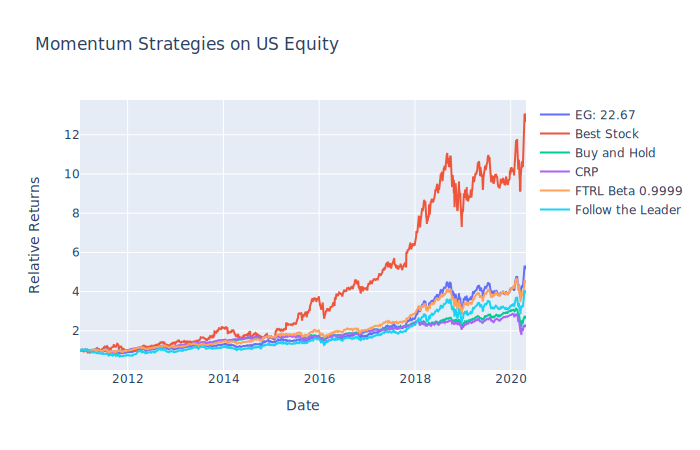

In [43]:
fig = go.Figure()
idx = us_equity_bah.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=us_equity_large_eta_list[us_equity_large_eta_optuna.best_trial.number].portfolio_return['Returns'], name="EG: 22.67"))
fig.add_trace(go.Scatter(x=idx, y=us_equity_beststock.portfolio_return['Returns'], name="Best Stock"))
fig.add_trace(go.Scatter(x=idx, y=us_equity_bah.portfolio_return['Returns'], name="Buy and Hold"))
fig.add_trace(go.Scatter(x=idx, y=us_equity_crp.portfolio_return['Returns'], name="CRP"))
fig.add_trace(go.Scatter(x=idx, y=us_equity_small_beta_list[us_equity_small_beta_optuna.best_trial.number].portfolio_return['Returns'], name="FTRL Beta 0.9999"))
fig.add_trace(go.Scatter(x=idx, y=us_equity_ftl.portfolio_return['Returns'], name="Follow the Leader"))
fig.update_layout(title='Momentum Strategies on US Equity', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

For US Equity, momentum strategies also outperform buy and hold. Starting from 2018, the gap between the benchmarks becomes larger as momentum catches onto Amazon's rapidly growing prices. There is still an insurmountable gap between the best stock and other strategies as Amazon has been performing incredibly well in the last decade. Moreover, the 10-year bull run allowed our strategies to progress well without too many drawdowns during the period.

## Conclusion

Through this notebook, we were able to explore the momentum functionalities of MlFinLab's newest Online Portfolio Selection module. Readers were exposed to a basic introduction to the momentum strategies and will be able to replicate results using the simple methods of the new module.

The next notebook will focus on Mean Reversion.

If you enjoyed reading this please remember to leave us a star on [GitHub](https://github.com/hudson-and-thames) and join our [Slack](https://join.slack.com/t/mlfinlab/shared_invite/zt-c62u9gpz-VFc13j6da~UVg3DkV7~RjQ) channel to ask us any questions!